In [62]:
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

In [4]:
ds = xr.open_mfdataset("../era5/era5-nordics-temperature-2000*.nc", chunks={"time": 12})

In [5]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 73, longitude: 111, time: 8785)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-01T01:00:00 ...
  * longitude  (longitude) float32 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 ...
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 70.5 70.25 70.0 ...
Dimensions without coordinates: bnds
Data variables:
    d2m        (time, latitude, longitude) float64 dask.array<shape=(8785, 73, 111), chunksize=(12, 73, 111)>
    t2m        (time, latitude, longitude) float64 dask.array<shape=(8785, 73, 111), chunksize=(12, 73, 111)>
    time_bnds  (time, bnds) float64 dask.array<shape=(8785, 2), chunksize=(8785, 2)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-11-16 09:49:48 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

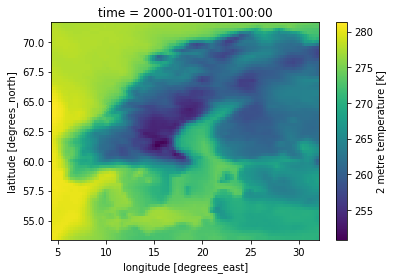

In [6]:
ds["t2m"][1].plot()

In [7]:
ds["temp_c"] = ds["t2m"] - 273.15

In [8]:
daily_temp_c = ds.temp_c.resample(time="D").mean("time")

In [127]:
daily_temp_c

<xarray.DataArray 'temp_c' (time: 366, latitude: 73, longitude: 111)>
dask.array<shape=(366, 73, 111), dtype=float64, chunksize=(1, 73, 111)>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
  * longitude  (longitude) float32 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 ...
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 70.5 70.25 70.0 ...

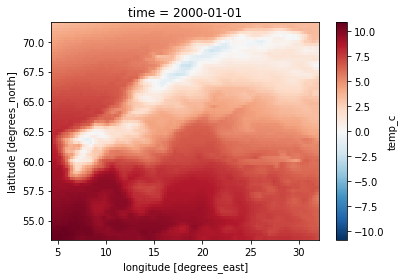

In [9]:
daily_temp_c.resample(time="AS").mean("time").plot()

In [11]:
pine = xr.open_dataset("pine.nc")

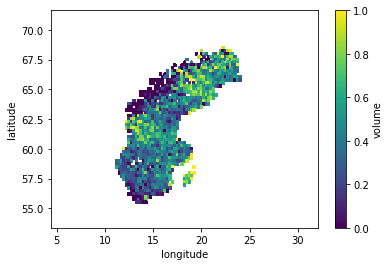

In [12]:
pine.volume.plot()

In [13]:
spruce = xr.open_dataset("spruce.nc")

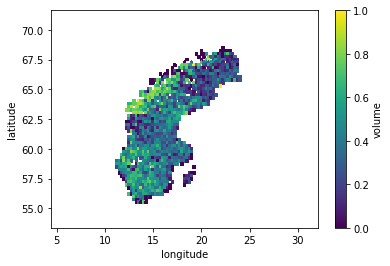

In [14]:
spruce.volume.plot()

In [15]:
df = pd.DataFrame()

In [104]:
temp_ranges = [(x, x+3) for x in range(-15, 27, 3)]
temp_ranges

[(-15, -12),
 (-12, -9),
 (-9, -6),
 (-6, -3),
 (-3, 0),
 (0, 3),
 (3, 6),
 (6, 9),
 (9, 12),
 (12, 15),
 (15, 18),
 (18, 21),
 (21, 24),
 (24, 27)]

In [105]:
temp_counts = {}
for idx, (x, y) in enumerate(temp_ranges):
    xlabel = "%02d" % x if x > 0 else "M%02d" % abs(x)
    ylabel = "%02d" % y if y > 0 else "M%02d" % abs(y)
    name = "temp_%s_%s" % (xlabel, ylabel)
    temp_counts[name] = daily_temp_c.where( (daily_temp_c > x) & (daily_temp_c < y) ).resample(time="AS").count("time")/366

In [131]:
temp_counts.keys()

dict_keys(['temp_M15_M12', 'temp_M12_M09', 'temp_M09_M06', 'temp_M06_M03', 'temp_M03_M00', 'temp_M00_03', 'temp_03_06', 'temp_06_09', 'temp_09_12', 'temp_12_15', 'temp_15_18', 'temp_18_21', 'temp_21_24', 'temp_24_27'])

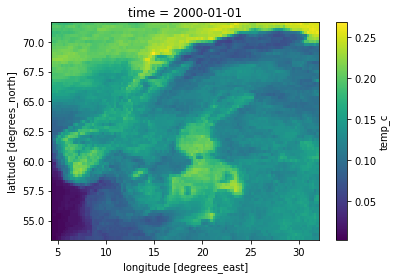

In [132]:
temp_counts["temp_M00_03"].plot()

In [106]:
data = {
    "pine": pine.to_array().values.ravel(),
    "spruce": spruce.to_array().values.ravel()
}

In [107]:
for k in tqdm(temp_counts.keys()):
    data[k] = temp_counts[k].values.ravel()

100%|██████████| 14/14 [00:55<00:00,  4.05s/it]


In [108]:
data.keys()

dict_keys(['pine', 'spruce', 'temp_M15_M12', 'temp_M12_M09', 'temp_M09_M06', 'temp_M06_M03', 'temp_M03_M00', 'temp_M00_03', 'temp_03_06', 'temp_06_09', 'temp_09_12', 'temp_12_15', 'temp_15_18', 'temp_18_21', 'temp_21_24', 'temp_24_27'])

In [109]:
df = pd.DataFrame(data)

In [110]:
df.dropna(inplace=True)

In [111]:
df

,pine,spruce,temp_M15_M12,temp_M12_M09,temp_M09_M06,temp_M06_M03,temp_M03_M00,temp_M00_03,temp_03_06,temp_06_09,temp_09_12,temp_12_15,temp_15_18,temp_18_21,temp_21_24,temp_24_27
1403,0.948005,0.000000,0.035519,0.079235,0.084699,0.084699,0.125683,0.081967,0.087432,0.125683,0.150273,0.043716,0.035519,0.005464,0.000000,0.000000
1505,0.903757,0.000000,0.040984,0.092896,0.084699,0.090164,0.112022,0.081967,0.106557,0.136612,0.122951,0.051913,0.021858,0.000000,0.000000,0.000000
1513,0.710386,0.000000,0.040984,0.071038,0.095628,0.076503,0.125683,0.084699,0.090164,0.112022,0.153005,0.051913,0.035519,0.005464,0.000000,0.000000
1514,0.000000,0.000000,0.043716,0.065574,0.090164,0.081967,0.120219,0.090164,0.087432,0.114754,0.150273,0.057377,0.035519,0.005464,0.000000,0.000000
1515,0.203855,0.000000,0.051913,0.071038,0.076503,0.073770,0.131148,0.090164,0.087432,0.109290,0.155738,0.060109,0.030055,0.010929,0.000000,0.000000
1516,0.872032,0.000000,0.051913,0.065574,0.084699,0.071038,0.120219,0.098361,0.084699,0.106557,0.161202,0.062842,0.030055,0.010929,0.000000,0.000000
1517,1.000000,0.000000,0.057377,0.057377,0.095628,0.062842,0.120219,0.098361,0.087432,0.103825,0.155738,0.062842,0.032787,0.013661,0.000000,0.000000
1614,0.000000,0.000000,0.054645,0.090164,0.076503,0.120219,0.103825,0.084699,0.106557,0.163934,0.087432,0.043716,0.010929,0.000000,0.000000,0.000000
1616,0.000000,0.000000,0.038251,0.092896,0.079235,0.098361,0.101093,0.079235,0.101093,0.131148,0.144809,0.043716,0.030055,0.002732,0.000000,0.000000
1617,0.679887,0.000000,0.038251,0.092896,0.068306,0.087432,0.109290,0.084699,0.095628,0.120219,0.150273,0.057377,0.032787,0.002732,0.000000,0.000000


In [112]:
df = df[ (df["pine"] > 0.5) | (df["spruce"] > 0.5) ]

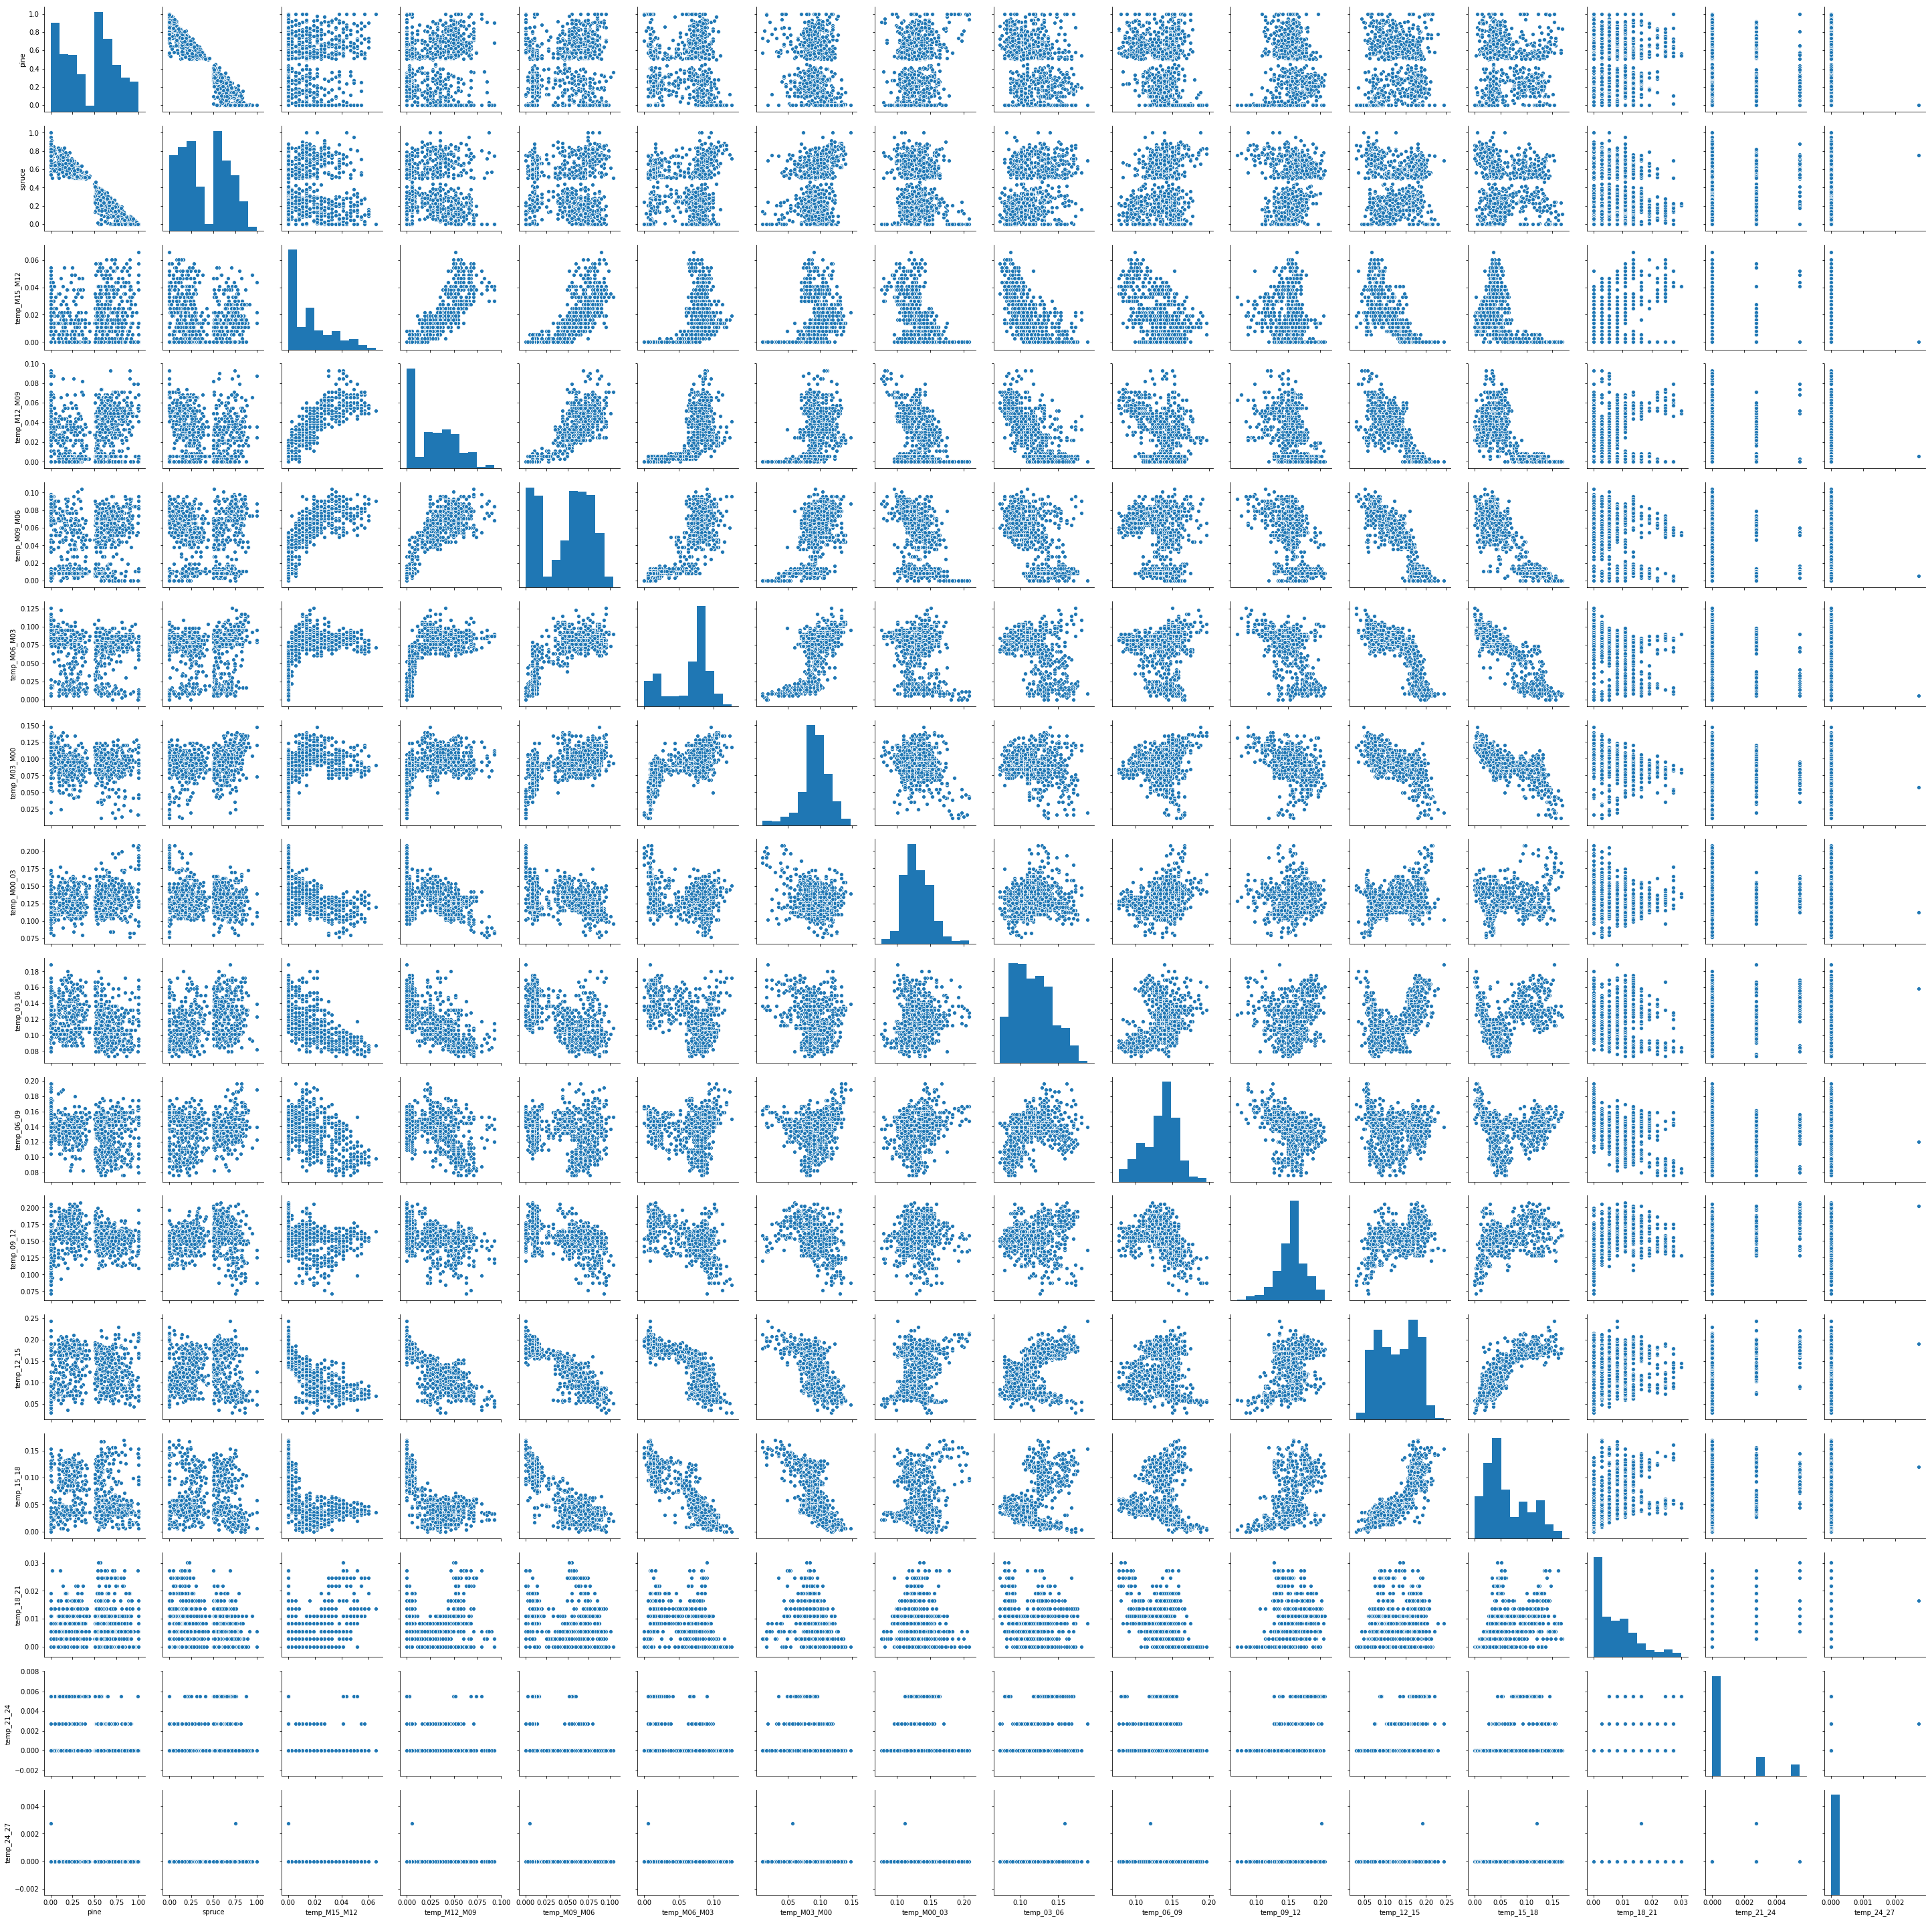

In [113]:
sns.pairplot(df)

In [114]:
df["class"] = df.apply(lambda row: 0 if row["pine"] > row["spruce"] else 1, axis=1)

/home/sato/dev/cc/sandbox-fabio/python-notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
df

,pine,spruce,temp_M15_M12,temp_M12_M09,temp_M09_M06,temp_M06_M03,temp_M03_M00,temp_M00_03,temp_03_06,temp_06_09,temp_09_12,temp_12_15,temp_15_18,temp_18_21,temp_21_24,temp_24_27,class
1403,0.948005,0.000000,0.035519,0.079235,0.084699,0.084699,0.125683,0.081967,0.087432,0.125683,0.150273,0.043716,0.035519,0.005464,0.000000,0.000000,0
1505,0.903757,0.000000,0.040984,0.092896,0.084699,0.090164,0.112022,0.081967,0.106557,0.136612,0.122951,0.051913,0.021858,0.000000,0.000000,0.000000,0
1513,0.710386,0.000000,0.040984,0.071038,0.095628,0.076503,0.125683,0.084699,0.090164,0.112022,0.153005,0.051913,0.035519,0.005464,0.000000,0.000000,0
1516,0.872032,0.000000,0.051913,0.065574,0.084699,0.071038,0.120219,0.098361,0.084699,0.106557,0.161202,0.062842,0.030055,0.010929,0.000000,0.000000,0
1517,1.000000,0.000000,0.057377,0.057377,0.095628,0.062842,0.120219,0.098361,0.087432,0.103825,0.155738,0.062842,0.032787,0.013661,0.000000,0.000000,0
1617,0.679887,0.000000,0.038251,0.092896,0.068306,0.087432,0.109290,0.084699,0.095628,0.120219,0.150273,0.057377,0.032787,0.002732,0.000000,0.000000,0
1618,0.364010,0.503929,0.046448,0.081967,0.071038,0.084699,0.117486,0.079235,0.095628,0.112022,0.161202,0.060109,0.032787,0.002732,0.000000,0.000000,1
1622,0.274764,0.588352,0.049180,0.068306,0.071038,0.092896,0.114754,0.092896,0.092896,0.101093,0.158470,0.062842,0.030055,0.008197,0.000000,0.000000,1
1623,1.000000,0.000000,0.049180,0.068306,0.081967,0.079235,0.117486,0.092896,0.092896,0.098361,0.161202,0.062842,0.027322,0.010929,0.000000,0.000000,0
1625,0.551719,0.000000,0.057377,0.068306,0.079235,0.073770,0.117486,0.103825,0.079235,0.103825,0.161202,0.062842,0.032787,0.010929,0.000000,0.000000,0


In [117]:
df.columns

Index(['pine', 'spruce', 'temp_M15_M12', 'temp_M12_M09', 'temp_M09_M06',
       'temp_M06_M03', 'temp_M03_M00', 'temp_M00_03', 'temp_03_06',
       'temp_06_09', 'temp_09_12', 'temp_12_15', 'temp_15_18', 'temp_18_21',
       'temp_21_24', 'temp_24_27', 'class'],
      dtype='object')

In [118]:
rf = RandomForestClassifier(n_estimators=500, max_depth=10)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[2:-2]], df["class"])

In [120]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [121]:
y_pred = rf.predict(X_test)

In [122]:
accuracy_score(y_pred, y_test)

0.7487179487179487

In [123]:
confusion_matrix(y_pred, y_test)

array([[79, 19],
       [30, 67]])

In [124]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [125]:
feature_importances

,importance
temp_06_09,0.111224
temp_09_12,0.109332
temp_03_06,0.103784
temp_M06_M03,0.091195
temp_12_15,0.089547
temp_15_18,0.085534
temp_M12_M09,0.077263
temp_M00_03,0.075871
temp_M09_M06,0.070654
temp_M03_M00,0.069909


<BarContainer object of 13 artists>

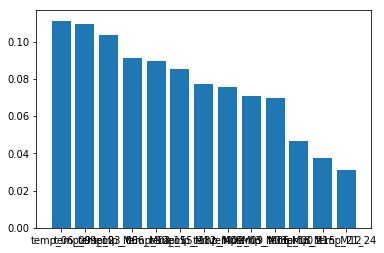

In [126]:
plt.bar(feature_importances.index, feature_importances["importance"])